In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
import os

import tensorflow as tf
from tensorflow.keras.layers import Input,Dropout,Dense,Flatten,Activation,MaxPooling2D,Convolution2D,AveragePooling2D,BatchNormalization,Concatenate
from keras import regularizers
from keras import initializers
from tensorflow.keras.optimizers import Adam
from keras import backend
from keras import Model
from keras.utils.vis_utils import plot_model
import pydot

import xml.etree.ElementTree as xet

2023-01-03 09:15:51.373044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 09:15:52.114132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-03 09:15:52.114148: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 09:15:52.214519: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been re

In [2]:
def conv2D(x,filters,rows,columns,padding='same',strides=(1,1),use_bias=True):
    channel_axis=0
    if(backend.image_data_format()=='channels_first'):
        channel_axis=1
    else:
        channel_axis=-1
    x1=Convolution2D(filters=filters,kernel_size=(rows,columns),strides=strides,padding=padding,use_bias=use_bias,kernel_regularizer=regularizers.l2(0.00005),kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.RandomUniform(0,0.1))(x)
    x2=BatchNormalization(axis=channel_axis,momentum=0.995,scale=False)(x1)
    Final=Activation('relu')(x2)
    return Final                      

In [3]:
def block_main_A(x):
    channel_axis=0
    if(backend.image_data_format()=='channels_first'):
        channel_axis=1
    else:
        channel_axis=-1
    x1=conv2D(x,64,1,1,'same',(1,1),False)
    x1=conv2D(x1,96,3,3,'same',(1,1),False)
    x1=conv2D(x1,96,3,3,'same',(1,1),False)
    
    x2=conv2D(x,64,1,1,'same',(1,1),False)
    x2=conv2D(x2,96,3,3,'same',(1,1),False)
    
    x3=conv2D(x,96,1,1,'same',(1,1),False)
    
    x4=AveragePooling2D(pool_size=(2,2),padding='same',strides=(1,1))(x)
    x4=conv2D(x4,96,1,1,'same',(1,1),False)
    
    Final=Concatenate(axis=channel_axis)([x1,x2,x3,x4])
    return Final

In [4]:
def block_main_B(x):
    channel_axis=0
    if(backend.image_data_format()=='channels_first'):
        channel_axis=1
    else:
        channel_axis=-1
            
    x1=conv2D(x,192,1,1,'same',(1,1),False)
    x1=conv2D(x1,192,1,7,'same',(1,1),False)
    x1=conv2D(x1,224,7,1,'same',(1,1),False)
    x1=conv2D(x1,224,1,7,'same',(1,1),False)
    x1=conv2D(x1,256,7,1,'same',(1,1),False)
    
    x2=conv2D(x,192,1,1,'same',(1,1),False)
    x2=conv2D(x2,224,1,7,'same',(1,1),False)
    x2=conv2D(x2,256,7,1,'same',(1,1),False)
    
    x3=conv2D(x,384,1,1,'same',(1,1),False)
    
    x4=AveragePooling2D(pool_size=(2,2),padding='same',strides=(1,1))(x)
    x4=conv2D(x4,128,1,1,'same',(1,1),False)
    
    Final=Concatenate(axis=channel_axis)([x1,x2,x3,x4])
    return Final
    

In [5]:
def block_main_C(x):
    channel_axis=0
    if(backend.image_data_format()=='channels_first'):
        channel_axis=1
    else:
        channel_axis=-1
            
    x1=conv2D(x,384,1,1,'same',(1,1),False)
    x1=conv2D(x1,448,1,3,'same',(1,1),False)
    x1=conv2D(x1,512,3,1,'same',(1,1),False)
    x11=conv2D(x1,256,3,1,'same',(1,1),False)
    x12=conv2D(x1,256,1,3,'same',(1,1),False)
    x1=Concatenate(axis=channel_axis)([x11,x12])
    
    x2=conv2D(x,384,1,1,'same',(1,1),False)
    x21=conv2D(x2,256,1,3,'same',(1,1),False)
    x22=conv2D(x2,256,3,1,'same',(1,1),False)
    x2=Concatenate(axis=channel_axis)([x21,x22])
    
    x3=conv2D(x,256,1,1,'same',(1,1),False)
    
    x4=AveragePooling2D(pool_size=(2,2),padding='same',strides=(1,1))(x)
    x4=conv2D(x4,256,1,1,'same',(1,1),False)
    
    Final=Concatenate(axis=channel_axis)([x1,x2,x3,x4])
    return Final
    

In [6]:
def stem(x):
    channel_axis=0
    if(backend.image_data_format()=='channels_first'):
        channel_axis=1
    else:
        channel_axis=-1    
        
    x1=conv2D(x,32,3,3,'valid',(2,2),False)
    x1=conv2D(x1,32,3,3,'valid',(1,1),False)
    x1=conv2D(x1,64,3,3,'same',(1,1),False)
    x11=MaxPooling2D(strides=(2,2),pool_size=(3,3),padding='valid')(x1)
    x12=conv2D(x1,96,3,3,'valid',(2,2),False)
    
    x2=Concatenate(axis=channel_axis)([x11,x12])
    
    x21=conv2D(x2,64,1,1,'same',(1,1),False)
    x21=conv2D(x21,96,3,3,'valid',(1,1),False)
    
    x22=conv2D(x2,64,1,1,'same',(1,1),False)
    x22=conv2D(x22,64,7,1,'same',(1,1),False)
    x22=conv2D(x22,64,1,7,'same',(1,1),False)
    x22=conv2D(x22,96,3,3,'valid',(1,1),False)
    
    x3=Concatenate(axis=channel_axis)([x21,x22])
    
    x31=conv2D(x3,192,3,3,'valid',(2,2),False)
    x32=MaxPooling2D(strides=(2,2),pool_size=(2,2),padding='valid')(x3)
    
    Final=Concatenate(axis=channel_axis)([x31,x32])
    return Final

In [7]:
def reduction_A(x):
    channel_axis=0
    if(backend.image_data_format()=='channels_first'):
        channel_axis=1
    else:
        channel_axis=-1
    x1=MaxPooling2D(strides=(2,2),padding='valid',pool_size=(3,3))(x)
    x2=conv2D(x,384,3,3,'valid',(2,2),False)
    x3=conv2D(x,192,1,1,'same',(1,1),False)
    x3=conv2D(x3,224,3,3,'same',(1,1),False)
    x3=conv2D(x3,256,3,3,'valid',(2,2),False)
    
    Final=Concatenate(axis=channel_axis)([x1,x2,x3])
    return Final

In [8]:
def reduction_B(x):
    channel_axis=0
    if(backend.image_data_format()=='channels_first'):
        channel_axis=1
    else:
        channel_axis=-1
    x1=MaxPooling2D(strides=(2,2),padding='valid',pool_size=(3,3))(x)
    
    x2=conv2D(x,192,1,1,'same',(1,1),False)
    x2=conv2D(x2,192,3,3,'valid',(2,2),False)
    
    x3=conv2D(x,256,1,1,'same',(1,1),False)
    x3=conv2D(x3,256,1,7,'same',(1,1),False)
    x3=conv2D(x3,320,7,1,'same',(1,1),False)
    x3=conv2D(x3,320,3,3,'valid',(2,2),False)
    
    Final=Concatenate(axis=channel_axis)([x1,x2,x3])
    return Final

In [9]:
def inception_model():
    channel_axis=0
    if(backend.image_data_format()=='channels_first'):
        channel_axis=1
        inputs=Input((3,299,299))
    else:
        channel_axis=-1
        inputs=Input((299,299,3))
    x=stem(inputs)
    
    for i in range(4):
        x=block_main_A(x)
    x=reduction_A(x)
    
    for i in range(7):
        x=block_main_B(x)
    x=reduction_B(x)
    
    for i in range(3):
        x=block_main_C(x)
    
    x=AveragePooling2D((8,8),padding='valid')(x)
    x=Dropout(0.5)(x)
    x=Flatten()(x)
    x=Dense(units=768,activation='relu')(x)
    x=Dense(units=256,activation='relu')(x)
    x=Dense(units=4,activation='sigmoid')(x)
    
    model=Model(inputs,x,name='inception-v4')
    return model

In [10]:
from glob import glob

training_path=glob('Training/*.xml')

labels=pd.DataFrame(columns=['filepath','xmin','xmax','ymin','ymax'],index=[i for i in range(1000)])
i=0

for filename in training_path:
    info=xet.parse(filename).getroot().find('object').find('bndbox')
    file=xet.parse(filename).getroot().find('filename').text
    
    labels['filepath'][i]=os.path.join('Training',file)
    labels['xmin'][i]=int(info.find('xmin').text)
    labels['xmax'][i]=int(info.find('xmax').text)
    labels['ymin'][i]=int(info.find('ymin').text)
    labels['ymax'][i]=int(info.find('ymax').text)
    i+=1

labels.dropna(inplace=True)

labels['xmin']=pd.to_numeric(labels['xmin'])
labels['xmax']=pd.to_numeric(labels['xmax'])
labels['ymin']=pd.to_numeric(labels['ymin'])
labels['ymax']=pd.to_numeric(labels['ymax'])

labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 224
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  225 non-null    object
 1   xmin      225 non-null    int64 
 2   xmax      225 non-null    int64 
 3   ymin      225 non-null    int64 
 4   ymax      225 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.5+ KB


In [11]:
labels.head(10)

filepath  xmin  xmax  ymin  ymax
0    Training/N1.jpeg  1093  1396   645   727
1  Training/N100.jpeg   134   301   312   350
2  Training/N101.jpeg    31   139   128   161
3  Training/N102.jpeg   164   316   216   243
4  Training/N103.jpeg   813  1067   665   724
5  Training/N104.jpeg    66   154   166   197
6  Training/N105.jpeg   360   434   174   195
7  Training/N106.jpeg   137   262   249   290
8  Training/N107.jpeg   207   356   174   287
9  Training/N108.jpeg   184   342   220   257

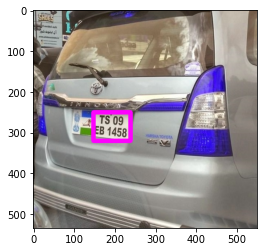

In [12]:
img=cv2.imread(labels['filepath'][10])
cv2.rectangle(img,pt1=(labels['xmin'][10],labels['ymin'][10]),pt2=(labels['xmax'][10],labels['ymax'][10]),color=(255,0,255),thickness=10)
plt.imshow(img)

In [13]:
from tensorflow.keras.preprocessing.image import load_img

training=[]

for i in range(len(labels)):
    image=cv2.imread(labels['filepath'][i])
    img_array=np.array(load_img(labels['filepath'][i],target_size=(299,299)))
    
    h,w,d=image.shape
    img_array=img_array/float(255)
    training.append(img_array)
    
    labels['xmin'][i]=labels['xmin'][i]/float(w)
    labels['xmax'][i]=labels['xmax'][i]/float(w)
    labels['ymin'][i]=labels['ymin'][i]/float(h)
    labels['ymax'][i]=labels['ymax'][i]/float(h)
    
labels=labels.drop('filepath',axis=1)

/tmp/ipykernel_1645/2766834871.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['xmin'][i]=labels['xmin'][i]/float(w)
/tmp/ipykernel_1645/2766834871.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['xmax'][i]=labels['xmax'][i]/float(w)
/tmp/ipykernel_1645/2766834871.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['ymin'][i]=labels['ymin'][i]/float(h)
/tmp/ipykernel_1645/2766834871.py:16: SettingWithCop

In [14]:
x=np.array(training,dtype=np.float32)
y=np.array(labels,ndmin=4,dtype=np.float32)
y=y.reshape((225,4))

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=True,random_state=12)

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(180, 299, 299, 3) (180, 4) (45, 299, 299, 3) (45, 4)


In [15]:
model=inception_model()
model.compile(Adam(lr=0.0001),loss='mse')

model.summary()

2023-01-03 09:16:00.423144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-03 09:16:00.423177: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 09:16:00.423192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (parrot): /proc/driver/nvidia/version does not exist
2023-01-03 09:16:00.423356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "inception-v4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 activation_5 (Activation)      (None, 71, 71, 96)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_9 (Activation)      (None, 71, 71, 96)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 concatenate_1 (Concatenate)    (None, 71, 71, 192)  0           ['activation_5[0][0]',           
                                                                  'activation_9[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 35, 35, 192)  331776      ['concatenate_1[0][0]']          
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 192)  576        ['conv2d_10[0][0]']              
 ormalizat

 conv2d_19 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_18[0][0]']          
                                                                                                  
 conv2d_21 (Conv2D)             (None, 35, 35, 64)   24576       ['concatenate_3[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 35, 35, 96)  288         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_21 (BatchN  (None, 35, 35, 64)  192         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 35, 35, 96)  288         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_30 (BatchN  (None, 35, 35, 96)  288         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_31 (BatchN  (None, 35, 35, 96)  288         ['conv2d_31[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_40 (BatchN  (None, 35, 35, 192)  576        ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_40 (Activation)     (None, 35, 35, 192)  0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 35, 35, 224)  387072      ['activation_40[0][0]']          
                                                                                                  
 batch_normalization_41 (BatchN  (None, 35, 35, 224)  672        ['conv2d_41[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_52 (Conv2D)             (None, 17, 17, 128)  131072      ['average_pooling2d_4[0][0]']    
                                                                                                  
 batch_normalization_47 (BatchN  (None, 17, 17, 256)  768        ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_50 (BatchN  (None, 17, 17, 256)  768        ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_51 (BatchN  (None, 17, 17, 384)  1152       ['conv2d_51[0][0]']              
 ormalization)                                                                                    
          

/home/user/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 activation_47 (Activation)     (None, 17, 17, 256)  0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 activation_50 (Activation)     (None, 17, 17, 256)  0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 activation_51 (Activation)     (None, 17, 17, 384)  0           ['batch_normalization_51[0][0]'] 
                                                                                                  
 activation_52 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 concatena

                                                                                                  
 activation_61 (Activation)     (None, 17, 17, 384)  0           ['batch_normalization_61[0][0]'] 
                                                                                                  
 activation_62 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_62[0][0]'] 
                                                                                                  
 concatenate_9 (Concatenate)    (None, 17, 17, 1024  0           ['activation_57[0][0]',          
                                )                                 'activation_60[0][0]',          
                                                                  'activation_61[0][0]',          
                                                                  'activation_62[0][0]']          
                                                                                                  
 conv2d_63

 concatenate_10 (Concatenate)   (None, 17, 17, 1024  0           ['activation_67[0][0]',          
                                )                                 'activation_70[0][0]',          
                                                                  'activation_71[0][0]',          
                                                                  'activation_72[0][0]']          
                                                                                                  
 conv2d_73 (Conv2D)             (None, 17, 17, 192)  196608      ['concatenate_10[0][0]']         
                                                                                                  
 batch_normalization_73 (BatchN  (None, 17, 17, 192)  576        ['conv2d_73[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_83 (Conv2D)             (None, 17, 17, 192)  196608      ['concatenate_11[0][0]']         
                                                                                                  
 batch_normalization_83 (BatchN  (None, 17, 17, 192)  576        ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_83 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_83[0][0]']          
                                                                                                  
 batch_normalization_84 (BatchN  (None, 17, 17, 192)  576        ['conv2d_84[0][0]']              
 ormalizat

 activation_93 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_93[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 17, 17, 192)  576        ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_95 (Conv2D)             (None, 17, 17, 224)  301056      ['activation_94[0][0]']          
          

 Normalization)                                                                                   
                                                                                                  
 activation_104 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_104[0][0]']
                                                                                                  
 conv2d_105 (Conv2D)            (None, 17, 17, 224)  301056      ['activation_104[0][0]']         
                                                                                                  
 conv2d_108 (Conv2D)            (None, 17, 17, 192)  196608      ['concatenate_13[0][0]']         
                                                                                                  
 batch_normalization_105 (Batch  (None, 17, 17, 224)  672        ['conv2d_105[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_117 (Conv2D)            (None, 17, 17, 320)  573440      ['activation_116[0][0]']         
                                                                                                  
 batch_normalization_113 (Batch  (None, 17, 17, 192)  576        ['conv2d_113[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_117 (Batch  (None, 17, 17, 320)  960        ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_113 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_113[0][0]']
          

                                                                                                  
 conv2d_127 (Conv2D)            (None, 8, 8, 256)    393216      ['concatenate_15[0][0]']         
                                                                                                  
 conv2d_128 (Conv2D)            (None, 8, 8, 256)    393216      ['average_pooling2d_11[0][0]']   
                                                                                                  
 activation_122 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_122[0][0]']
                                                                                                  
 activation_123 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_123[0][0]']
                                                                                                  
 activation_125 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_125[0][0]']
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_137 (Conv2D)            (None, 8, 8, 256)    393216      ['concatenate_18[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 8, 8, 256)    393216      ['average_pooling2d_12[0][0]']   
                                                                                                  
 activation_132 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_132[0][0]']
                                                                                                  
 activation_133 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_133[0][0]']
                                                                                                  
 activatio

 batch_normalization_146 (Batch  (None, 8, 8, 256)   768         ['conv2d_146[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_147 (Conv2D)            (None, 8, 8, 256)    393216      ['concatenate_21[0][0]']         
                                                                                                  
 conv2d_148 (Conv2D)            (None, 8, 8, 256)    393216      ['average_pooling2d_13[0][0]']   
                                                                                                  
 activation_142 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_142[0][0]']
                                                                                                  
 activation_143 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_143[0][0]']
          

In [16]:
plot_model(model,show_shapes=True,)


In [ ]:
history=model.fit(x=x_train,y=y_train,batch_size=15,steps_per_epoch=12,validation_data=(x_test,y_test),epochs=100)
model.save('numberplate_detection.h5')


Epoch 1/100
10/12 [========================>.....] - ETA: 15s - loss: 0.2446

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'y',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
def object_detection(path):
    image=cv2.imread(path)
    img_array=np.array(load_img(path,target_size=(299,299)))
    
    h,w,d=image.shape
    img_array.reshape((1,299,299,3))
    img_array=img_array/float(255)
    coords=model.predict(img_array)
    norm=np.array([w,w,h,h])
    coords=coords*norm
    return image,coords

In [199]:
path=
image,coords=object_detection(path)
cv2.rectangle(image,pt1=(coords[0],coords[2]),pt2=(coords[1],coords[3]),color=(0,255,0),thickness=10)
plt.imshow(image)

SyntaxError: invalid syntax (2739320408.py, line 1)

In [178]:
#For text extraction we will use tesseract
import pytesseract as pts

text=pt.image_to_string(image[coords[3]:coords[1],coords[2]:coords[0]])